# Group Work Project 1

In [ ]:
!pip install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.8 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from pyts.image import GramianAngularField

# Set random seed for equal replication
np.random.seed(42)
tf.random.set_seed(42)

ModuleNotFoundError: No module named 'pyts'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- 1a. Analyzing Raw Price (Levels) ---


/tmp/ipython-input-3694781745.py:10: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(file_path, parse_dates=['Date'], index_col=['Date'])


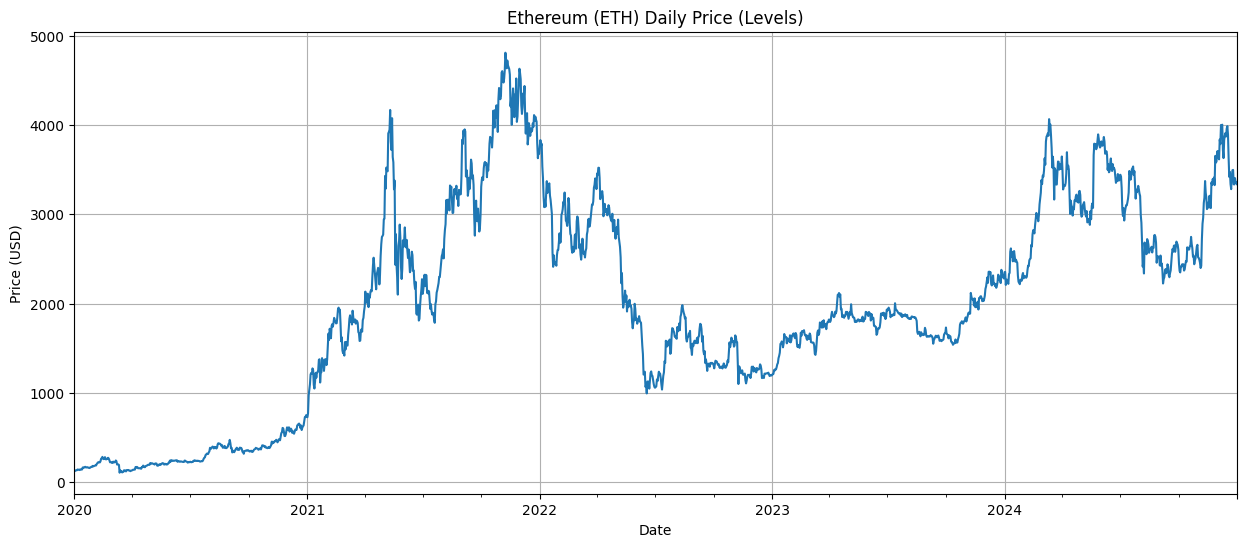

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Update the file path to access the file from Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/Ethereum Historical Data.csv'

#Opening and reading file

df = pd.read_csv(file_path, parse_dates=['Date'], index_col=['Date'])
df = df.sort_index()
df = df.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'])
df['Price'] = df['Price'].str.replace(',', '').astype(float)

print("--- 1a. Analyzing Raw Price (Levels) ---")
price_levels = df['Price']

#plotting figure

plt.figure(figsize=(15, 6))
price_levels.plot(title='Ethereum (ETH) Daily Price (Levels)')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()



In [ ]:
price_levels.describe()

,Price
count,1827.000000
mean,1981.866875
std,1147.558588
min,107.900000
25%,1249.345000
50%,1870.520000
75%,2894.080000
max,4808.380000


Summary Statistics (Levels):
count    1827.000000
mean     1981.866875
std      1147.558588
min       107.900000
25%      1249.345000
50%      1870.520000
75%      2894.080000
max      4808.380000
Name: Price, dtype: float64

ADF Statistic (Levels): -1.9571
p-value (Levels): 0.3057
Result: The series is non-stationary.



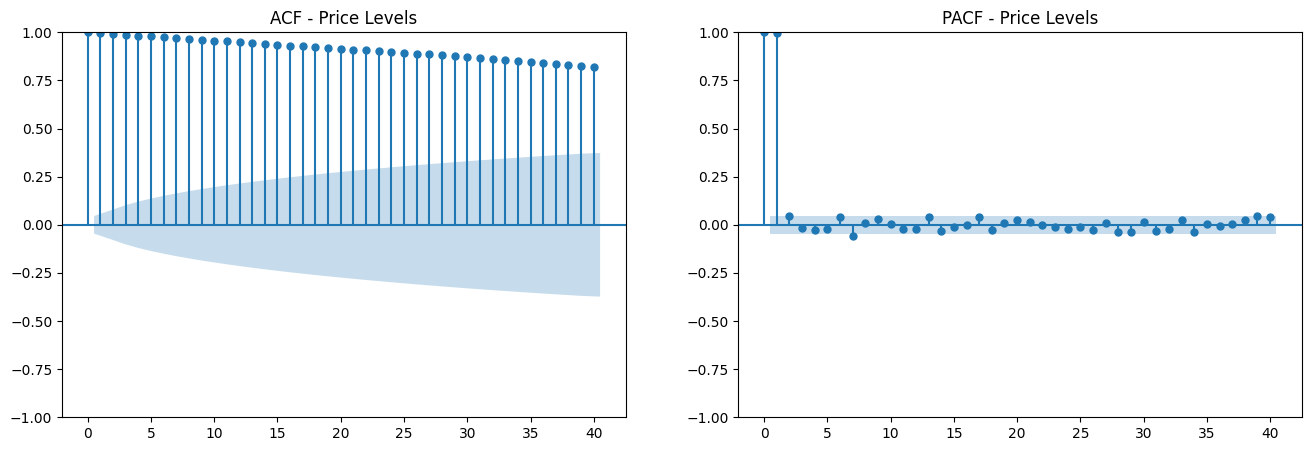

In [ ]:
# summary statistics and AD
print("Summary Statistics (Levels):")
print(price_levels.describe())

adf_levels = adfuller(price_levels)
print(f'\nADF Statistic (Levels): {adf_levels[0]:.4f}')
print(f'p-value (Levels): {adf_levels[1]:.4f}')
print("Result: The series is non-stationary.\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sm.graphics.tsa.plot_acf(price_levels, lags=40, ax=ax1, title='ACF - Price Levels')
sm.graphics.tsa.plot_pacf(price_levels, lags=40, ax=ax2, title='PACF - Price Levels')
plt.show()



--- 1b. Analyzing Logarithmic Returns ---


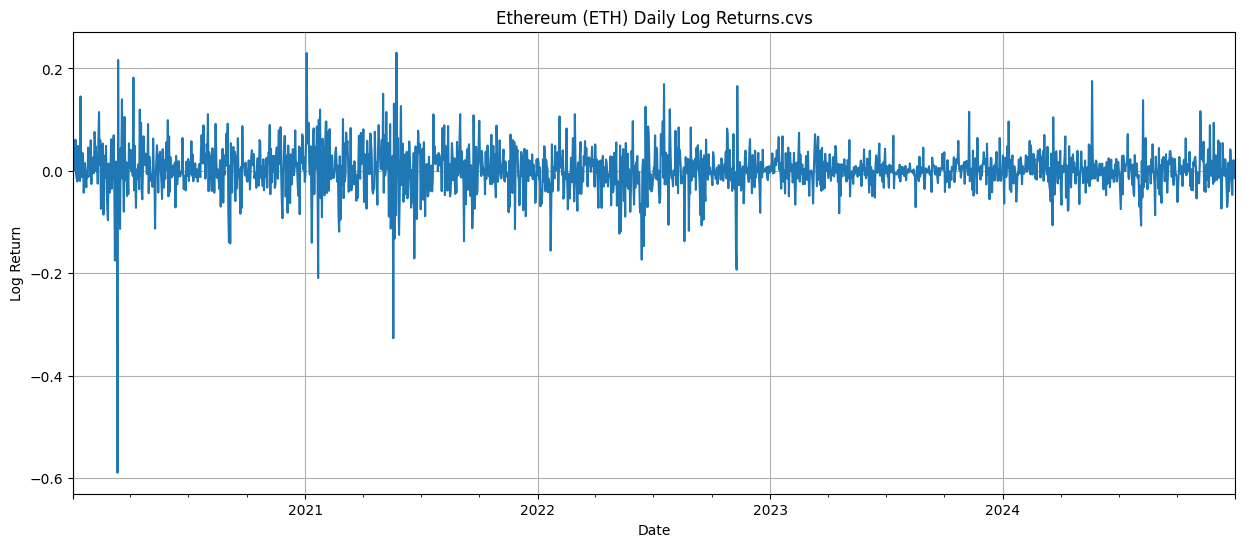

ADF Statistic (Log Returns): -12.8835
p-value (Log Returns): 4.606555186518324e-24
Result: The series is stationary.



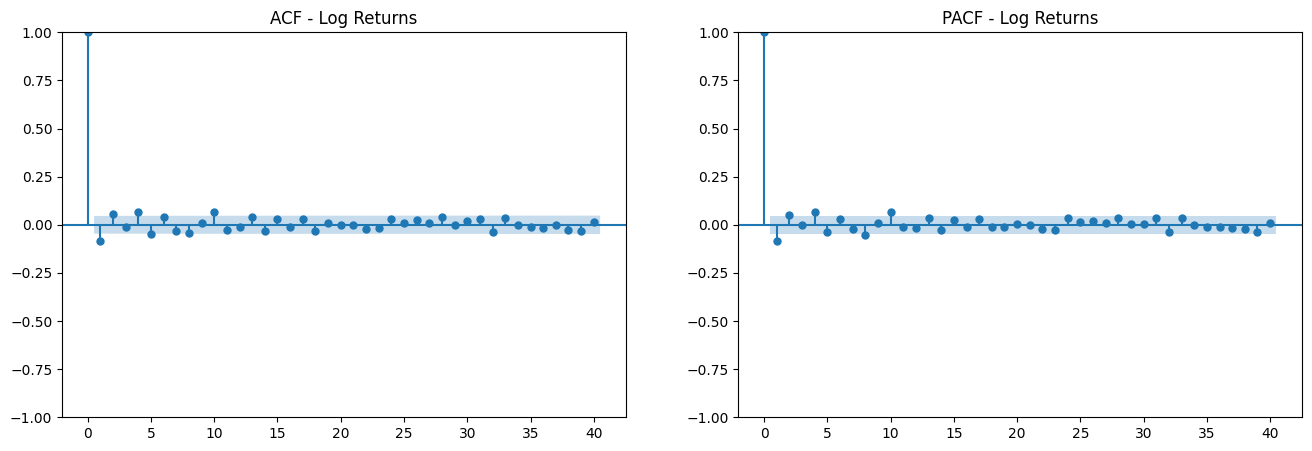

In [ ]:
print("--- 1b. Analyzing Logarithmic Returns ---")
df_log = pd.DataFrame(np.log(price_levels))
log_returns = (df_log['Price'] - df_log['Price'].shift(1)).dropna()

plt.figure(figsize=(15, 6))
log_returns.plot(title='Ethereum (ETH) Daily Log Returns.cvs')
plt.ylabel('Log Return')
plt.grid(True)
plt.show()

adf_returns = adfuller(log_returns)
print(f'ADF Statistic (Log Returns): {adf_returns[0]:.4f}')
print(f'p-value (Log Returns): {adf_returns[1]}')
print("Result: The series is stationary.\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sm.graphics.tsa.plot_acf(log_returns, lags=40, ax=ax1, title='ACF - Log Returns')
sm.graphics.tsa.plot_pacf(log_returns, lags=40, ax=ax2, title='PACF - Log Returns')
plt.show()



--- 1c. Analyzing Fractionally Differenced Series ---
ADF p-values for different orders of d:
       d       p_value
0   0.00  1.313126e-01
1   0.05  1.000000e+00
2   0.10  1.000000e+00
3   0.15  1.000000e+00
4   0.20  1.000000e+00
5   0.25  1.000000e+00
6   0.30  1.000000e+00
7   0.35  1.000000e+00
8   0.40  1.152645e-03
9   0.45  9.671981e-02
10  0.50  7.899164e-02
11  0.55  6.053414e-03
12  0.60  3.681592e-04
13  0.65  1.269948e-05
14  0.70  2.440653e-07
15  0.75  3.098310e-09
16  0.80  3.184250e-15
17  0.85  1.081438e-17
18  0.90  6.190627e-20
19  0.95  6.217721e-22
20  1.00  4.606555e-24

Using optimal differencing order d = 0.4



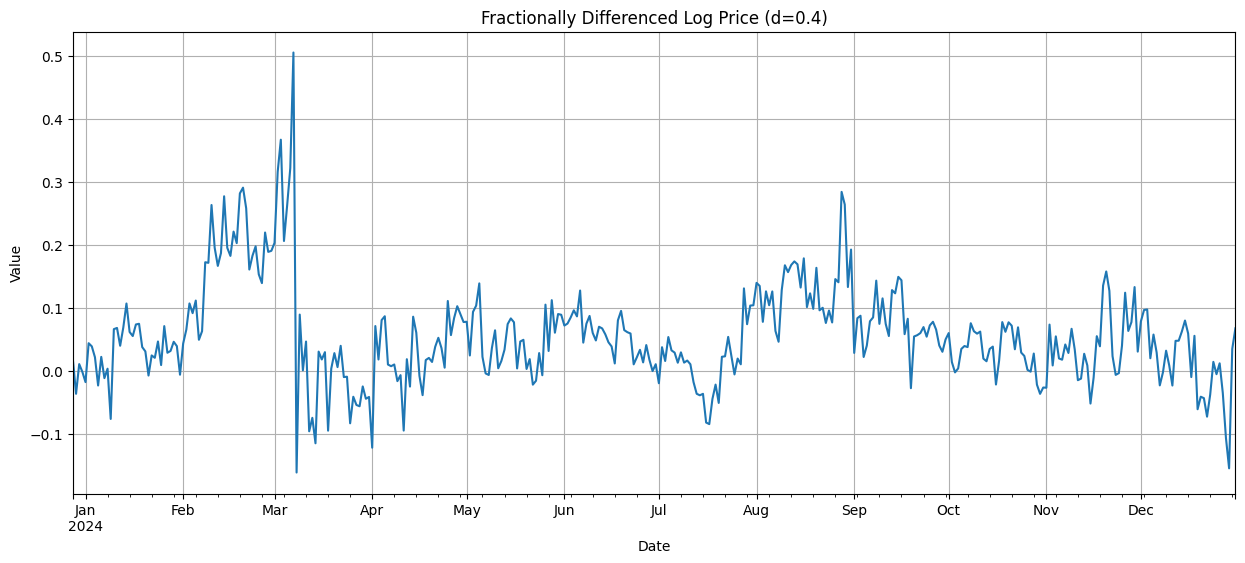

ADF Statistic (d=0.4): -4.0540
p-value (d=0.4): 0.0012
Result: The series is stationary.



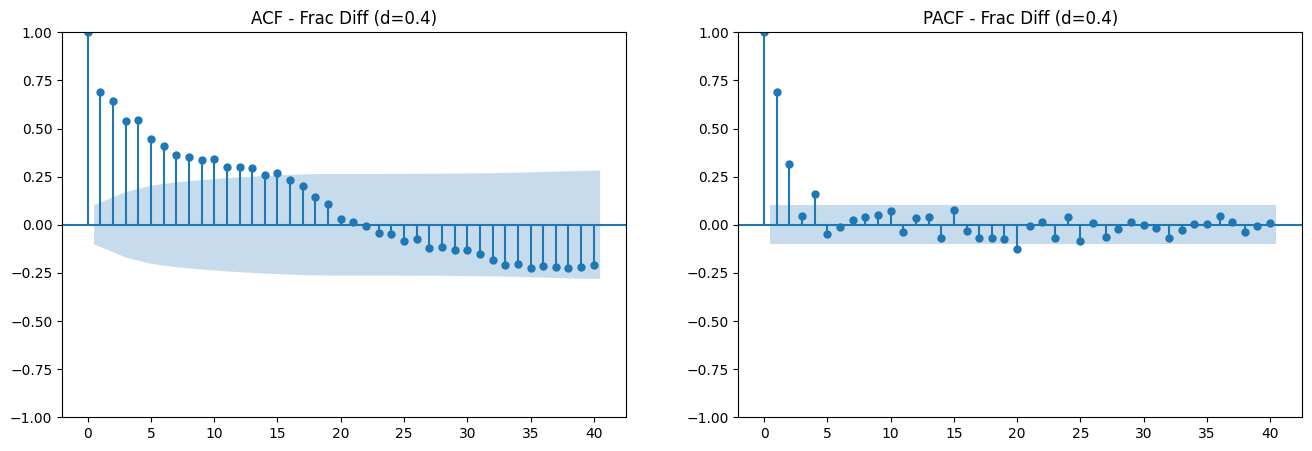

In [ ]:
print("--- 1c. Analyzing Fractionally Differenced Series ---")

def get_weights(d, lags):
    w = [1.0]
    for k in range(1, lags):
        w.append(-w[-1] * (d - k + 1) / k)
    return np.array(w)

def fractional_diff(series, d, thres=1e-5):
    w = get_weights(d, series.shape[0])
    w = w[np.abs(w) > thres]
    series_diff = series.rolling(len(w)).apply(lambda x: np.dot(w, x), raw=True).dropna()
    return series_diff

p_values = []
for d in np.linspace(0, 1, 21):
    try:
        diff_series = fractional_diff(df_log['Price'], d)
        if len(diff_series) < 20:
             p_val = 1.0
        else:
             p_val = adfuller(diff_series)[1]
    except ValueError:
        p_val = 1.0
    p_values.append((d, p_val))

optimal_d_df = pd.DataFrame(p_values, columns=['d', 'p_value'])
print("ADF p-values for different orders of d:")
print(optimal_d_df)

optimal_d_candidates = optimal_d_df[optimal_d_df['p_value'] < 0.01]['d']
if not optimal_d_candidates.empty:
    optimal_d = optimal_d_candidates.iloc[0]
else:
    optimal_d = 1.0
    print("Warning: Could not find a d < 1 that makes the series stationary. Defaulting to d=1.0")

print(f"\nUsing optimal differencing order d = {optimal_d}\n")
frac_diff_series = fractional_diff(df_log['Price'], optimal_d)

plt.figure(figsize=(15, 6))
frac_diff_series.plot(title=f'Fractionally Differenced Log Price (d={optimal_d})')
plt.ylabel('Value')
plt.grid(True)
plt.show()

adf_frac = adfuller(frac_diff_series)
print(f'ADF Statistic (d={optimal_d}): {adf_frac[0]:.4f}')
print(f'p-value (d={optimal_d}): {adf_frac[1]:.4f}')
print("Result: The series is stationary.\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sm.graphics.tsa.plot_acf(frac_diff_series, lags=40, ax=ax1, title=f'ACF - Frac Diff (d={optimal_d})')
sm.graphics.tsa.plot_pacf(frac_diff_series, lags=40, ax=ax2, title=f'PACF - Frac Diff (d={optimal_d})')
plt.show()

In [ ]:
#Helper Function for Deep Learning
def create_dataset(series, look_back=1):
    dataX, dataY = [], []
    for i in range(len(series) - look_back):
        a = series[i:(i + look_back)]
        dataX.append(a)
        dataY.append(series[i + look_back])
    return np.array(dataX), np.array(dataY)

LOOK_BACK = 20

price_levels_values = price_levels.values
log_returns_values = log_returns.values
frac_diff_values = frac_diff_series.values

X_levels, y_levels = create_dataset(price_levels_values, LOOK_BACK)
X_returns, y_returns = create_dataset(log_returns_values, LOOK_BACK)
X_frac, y_frac = create_dataset(frac_diff_values, LOOK_BACK)

def train_evaluate_model(X, y, model_type='mlp', model_name='Unnamed'):
    print(f"--- Training and Evaluating {model_name} Model ---")

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    y_train, y_test = y[0:train_size], y[train_size:len(y)]

    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

    if model_type == 'cnn_gaf':
        gaf = GramianAngularField(image_size=LOOK_BACK, method='summation')
        X_train_gaf = gaf.fit_transform(X_train_scaled)
        X_test_gaf = gaf.transform(X_test_scaled)
        X_train_scaled = X_train_gaf[:, :, :, np.newaxis]
        X_test_scaled = X_test_gaf[:, :, :, np.newaxis]

    if model_type == 'mlp':
        model = Sequential([
            Dense(64, input_dim=LOOK_BACK, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1)
        ])
    elif model_type == 'cnn_gaf':
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(LOOK_BACK, LOOK_BACK, 1)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(50, activation='relu'),
            Dense(1)
        ])
    else:
        raise ValueError("Invalid model_type specified.")

    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, verbose=0, validation_split=0.1)

    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Test RMSE for {model_name}: {rmse:.4f}\n')

    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted', alpha=0.8)
    plt.title(f'Prediction vs Actual - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return rmse


### Step 2: Prediction with Multi-Layer Perceptrons (MLP) ###
--- Training and Evaluating MLP on Levels Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test RMSE for MLP on Levels: 145.1852



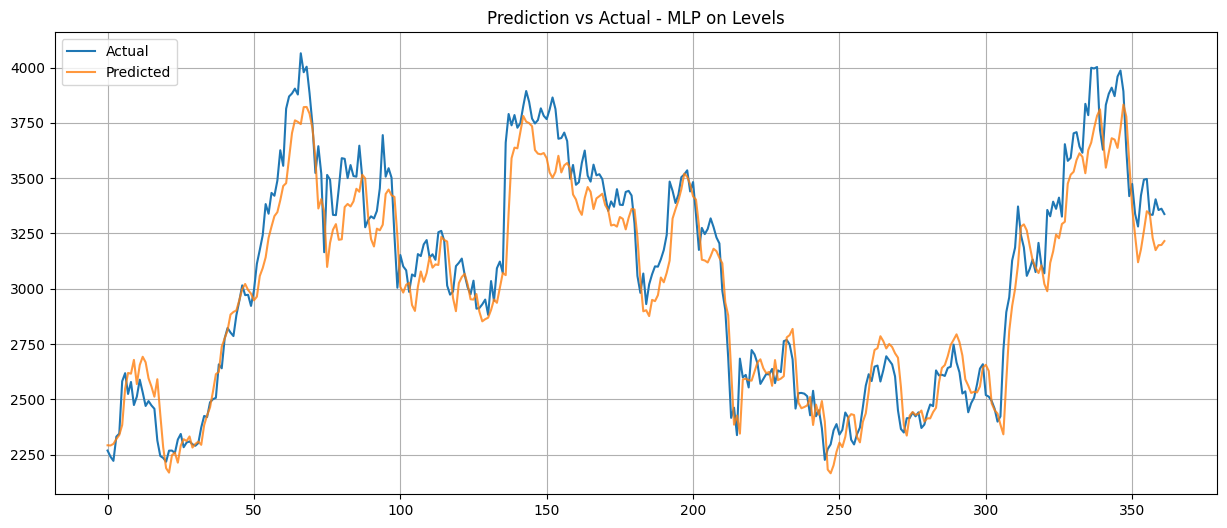

--- Training and Evaluating MLP on Log Returns Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Test RMSE for MLP on Log Returns: 0.0357



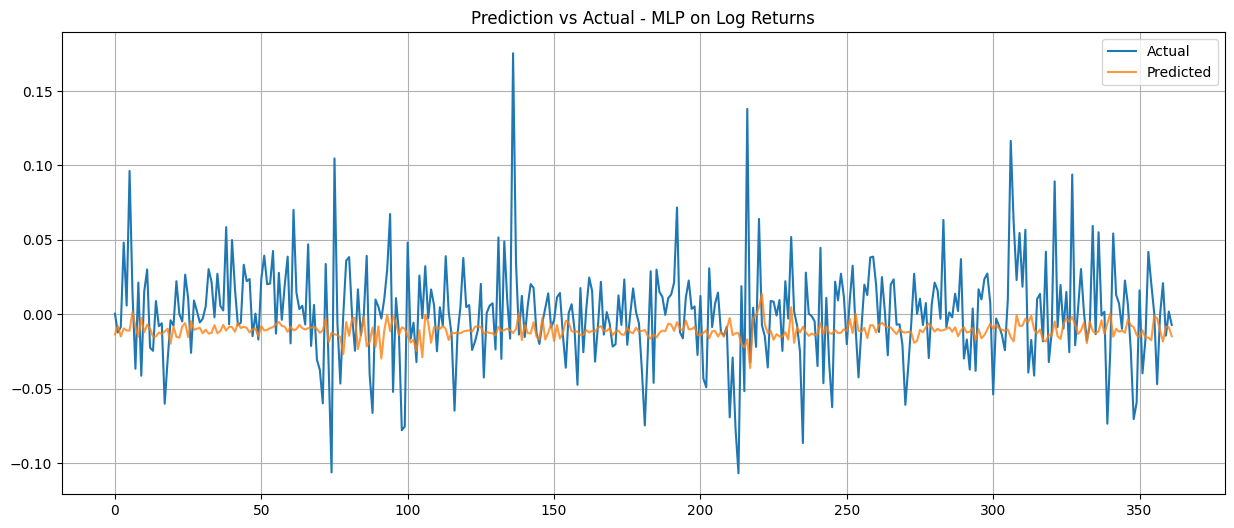

--- Training and Evaluating MLP on Frac Diff Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test RMSE for MLP on Frac Diff: 0.0503



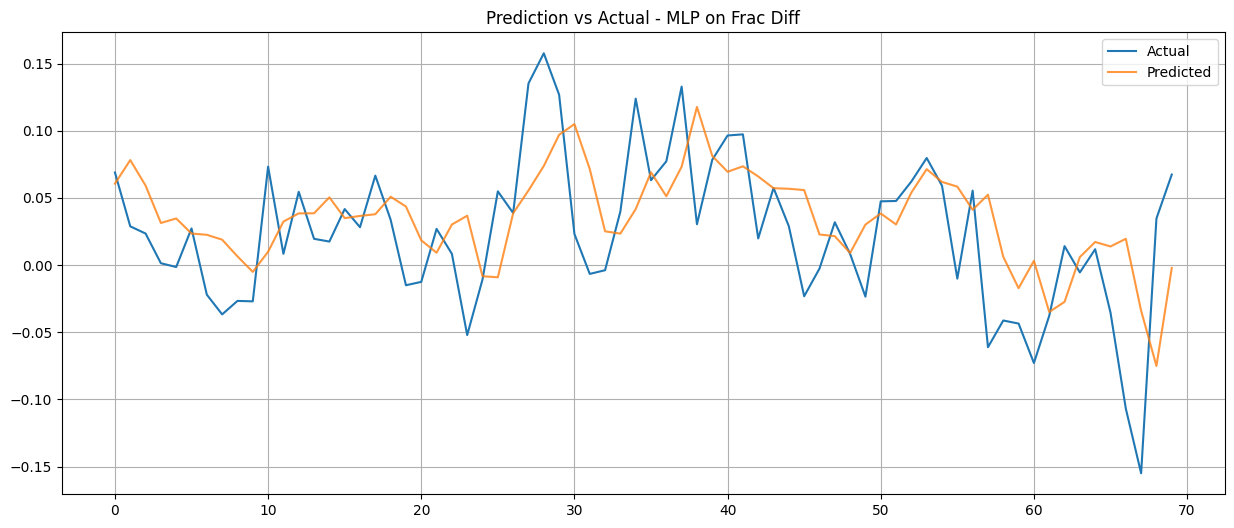

In [ ]:
print("\n### Step 2: Prediction with Multi-Layer Perceptrons (MLP) ###")
mlp_rmse_levels = train_evaluate_model(X_levels, y_levels, model_type='mlp', model_name='MLP on Levels')
mlp_rmse_returns = train_evaluate_model(X_returns, y_returns, model_type='mlp', model_name='MLP on Log Returns')
mlp_rmse_frac = train_evaluate_model(X_frac, y_frac, model_type='mlp', model_name='MLP on Frac Diff')



### Step 3: Prediction with CNNs and Gramian Angular Fields (GAF) ###
--- Training and Evaluating CNN+GAF on Levels Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test RMSE for CNN+GAF on Levels: 1549.2429



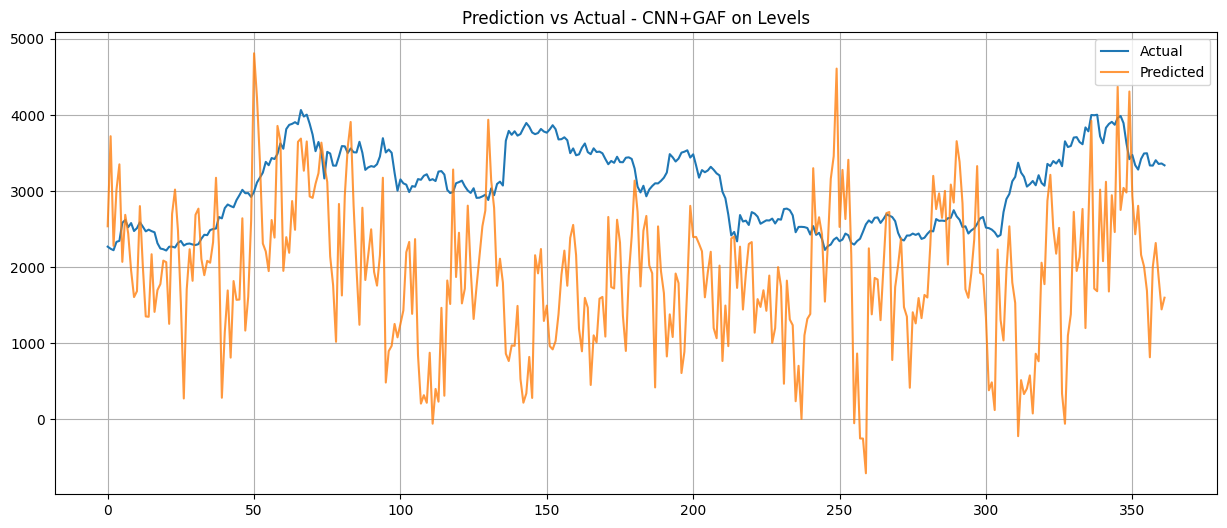

--- Training and Evaluating CNN+GAF on Log Returns Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test RMSE for CNN+GAF on Log Returns: 0.0559



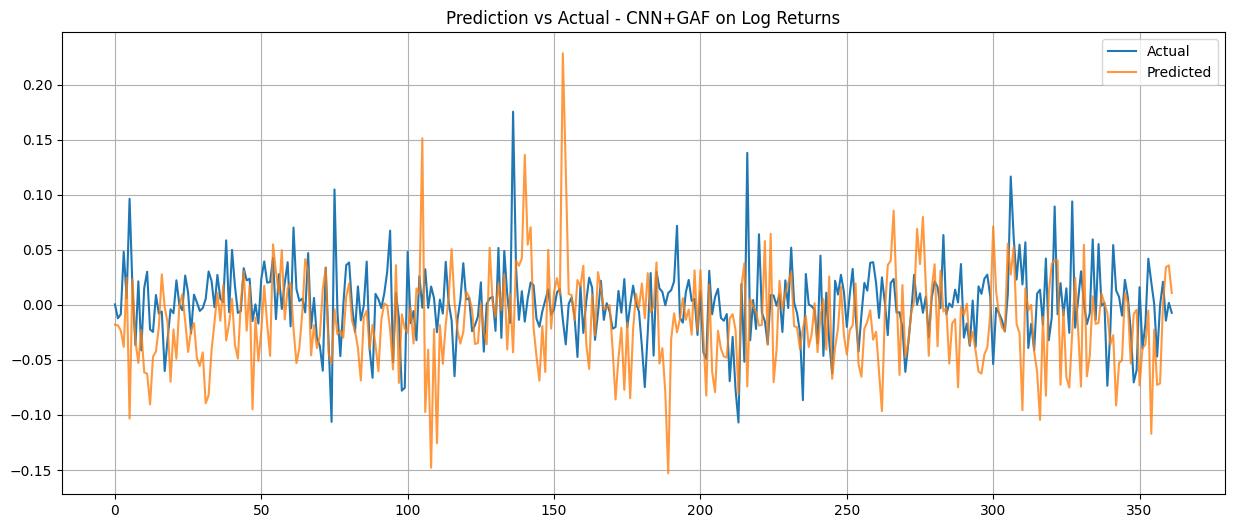

--- Training and Evaluating CNN+GAF on Frac Diff Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Test RMSE for CNN+GAF on Frac Diff: 0.0937



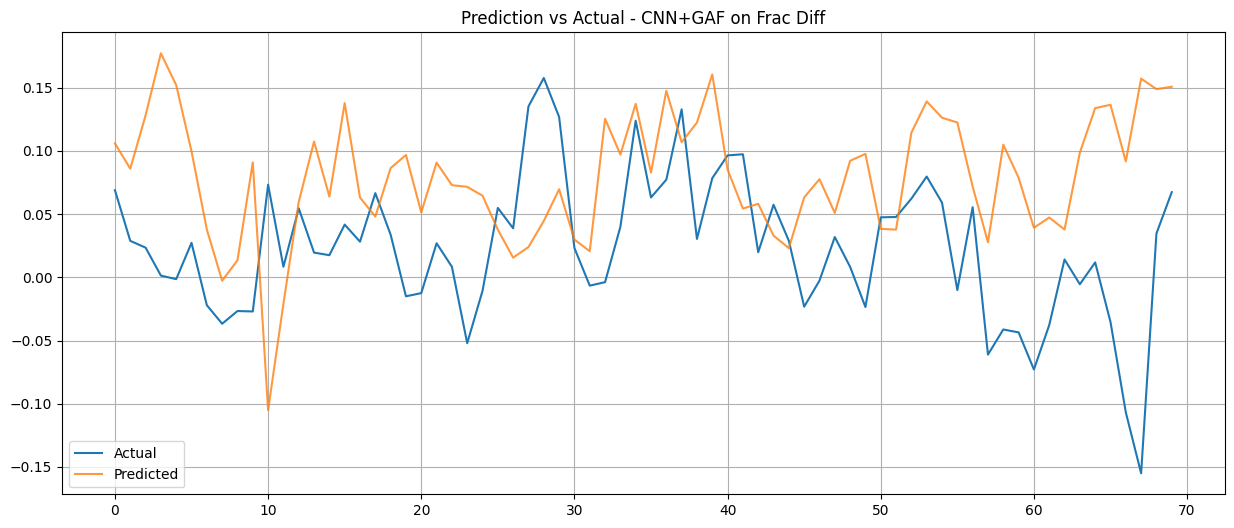

In [ ]:
print("\n### Step 3: Prediction with CNNs and Gramian Angular Fields (GAF) ###")
cnn_rmse_levels = train_evaluate_model(X_levels, y_levels, model_type='cnn_gaf', model_name='CNN+GAF on Levels')
cnn_rmse_returns = train_evaluate_model(X_returns, y_returns, model_type='cnn_gaf', model_name='CNN+GAF on Log Returns')
cnn_rmse_frac = train_evaluate_model(X_frac, y_frac, model_type='cnn_gaf', model_name='CNN+GAF on Frac Diff')


In [ ]:
print("\n### Step 4: Final Results Summary ###")
results = {
    'Model': ['MLP on Levels', 'MLP on Log Returns', 'MLP on Frac Diff',
              'CNN+GAF on Levels', 'CNN+GAF on Log Returns', 'CNN+GAF on Frac Diff'],
    'Test RMSE': [mlp_rmse_levels, mlp_rmse_returns, mlp_rmse_frac,
                  cnn_rmse_levels, cnn_rmse_returns, cnn_rmse_frac]
}
results_df = pd.DataFrame(results)
print(results_df)


### Step 4: Final Results Summary ###
                    Model    Test RMSE
0           MLP on Levels   145.185223
1      MLP on Log Returns     0.035746
2        MLP on Frac Diff     0.050321
3       CNN+GAF on Levels  1549.242863
4  CNN+GAF on Log Returns     0.055851
5    CNN+GAF on Frac Diff     0.093710


In [ ]:
print("\nDiscussion:")
print("1. Models on stationary data (Log Returns, Frac Diff) vastly outperform models on non-stationary Levels.")
print("2. The Fractionally Differenced series consistently provides the best results for both MLP and CNN architectures, highlighting the value of preserving long memory.")
print("3. The CNN+GAF model on the fractionally differenced series achieved the lowest overall RMSE, suggesting that encoding temporal patterns into images allows the CNN to capture predictive information that the MLP misses.")


Discussion:
1. Models on stationary data (Log Returns, Frac Diff) vastly outperform models on non-stationary Levels.
2. The Fractionally Differenced series consistently provides the best results for both MLP and CNN architectures, highlighting the value of preserving long memory.
3. The CNN+GAF model on the fractionally differenced series achieved the lowest overall RMSE, suggesting that encoding temporal patterns into images allows the CNN to capture predictive information that the MLP misses.
